# Question Answering

## Overview

Recall the overall workflow for retrieval augmented generation (RAG):

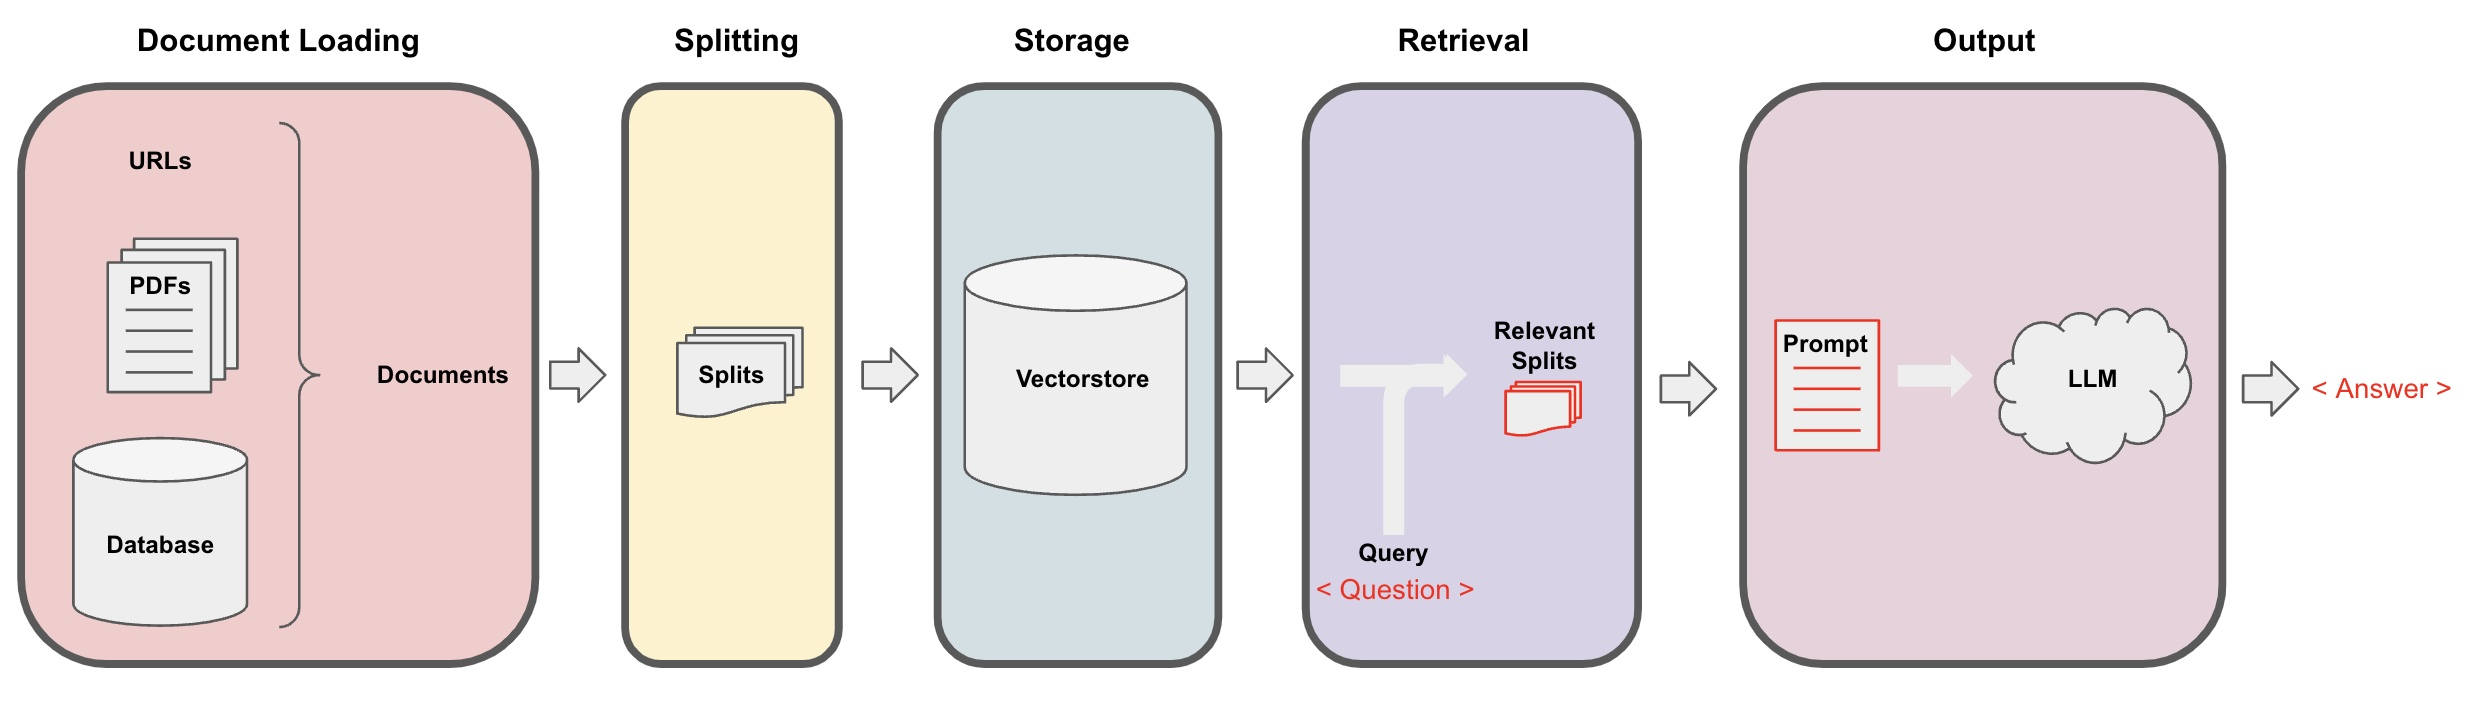

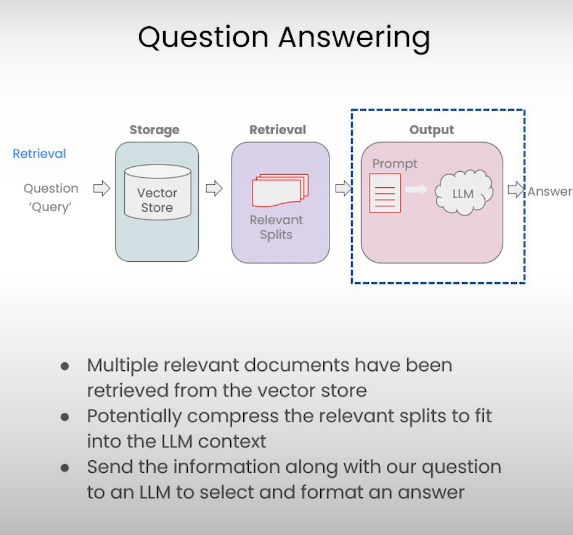

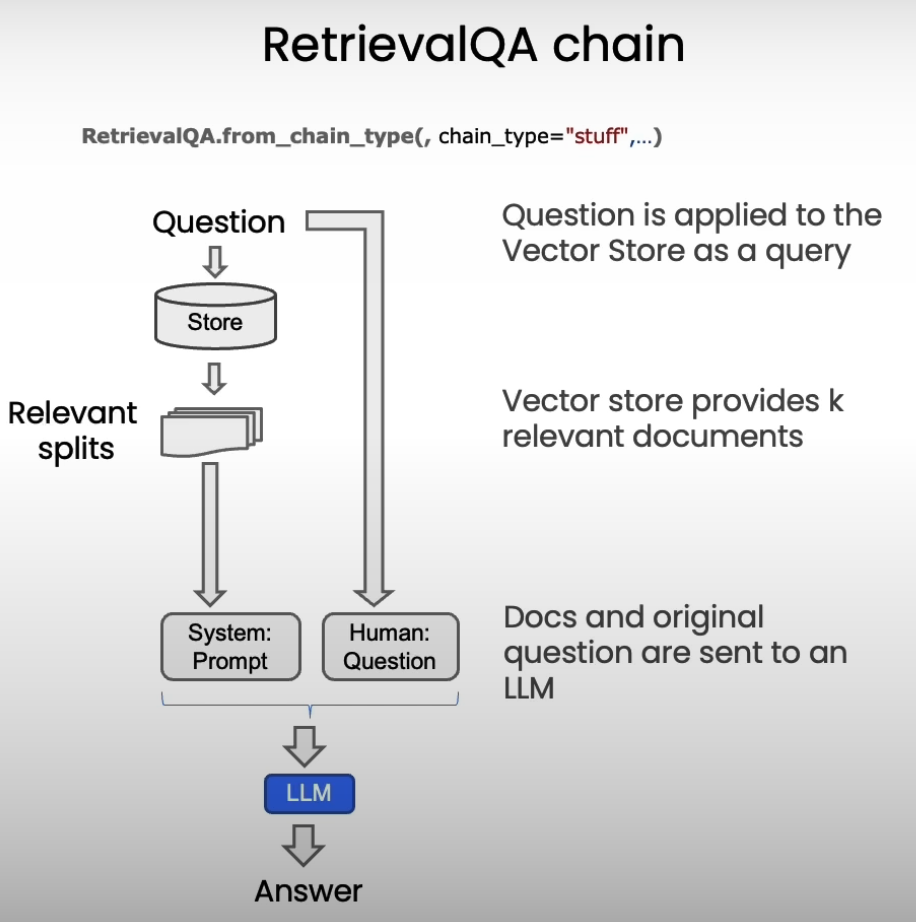

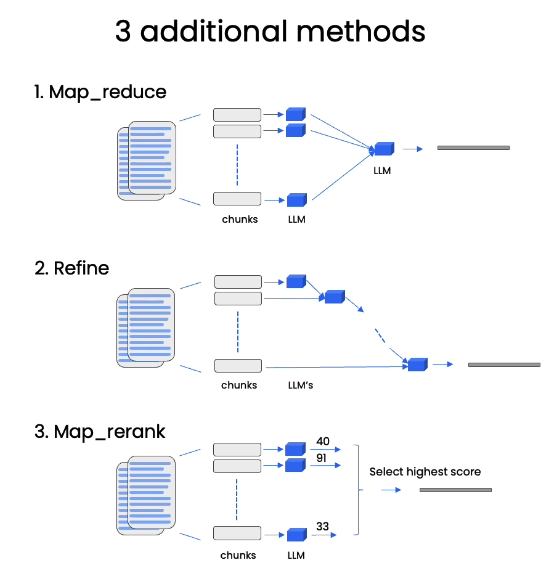

We discussed `Document Loading` and `Splitting` as well as `Storage` and `Retrieval`.

Let's load our vectorDB. 

In [1]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
persist_directory = 'data/docs/chroma/'
embedding = OpenAIEmbeddings()
vectordb = Chroma(persist_directory=persist_directory, embedding_function=embedding)

In [2]:
print(vectordb._collection.count())

209


In [3]:
question = "What are major topics for this class?"
docs = vectordb.similarity_search(question,k=3)
len(docs)

3

In [4]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

### RetrievalQA chain

In [5]:
from langchain.chains import RetrievalQA

In [6]:
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever()
)

In [7]:
result = qa_chain.invoke({"query": question})

In [8]:
result["result"]

'The major topics for this class include machine learning, statistics, algebra, and extensions of the material covered in the main lectures.'

### Prompt

In [9]:
from langchain_core.prompts import PromptTemplate

# Build prompt
template = """Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer. Use three sentences maximum. Keep the answer as concise as possible. Always say "thanks for asking!" at the end of the answer. 
{context}
Question: {question}
Helpful Answer:"""
QA_CHAIN_PROMPT = PromptTemplate.from_template(template)


In [10]:
# Run chain
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    return_source_documents=True, # this can let us to easily inspect the document that we retrieved
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)

In [11]:
question = "Is probability a class topic?"

In [12]:
result = qa_chain.invoke({"query": question})

In [13]:
result

{'query': 'Is probability a class topic?',
 'result': 'Yes, probability is a class topic as the instructor assumes familiarity with basic probability and statistics. Thanks for asking!',
 'source_documents': [Document(metadata={'page': 4, 'source': 'data/docs/cs229_lectures/MachineLearning-Lecture01.pdf'}, page_content="of this class will not be very program ming intensive, although we will do some \nprogramming, mostly in either MATLAB or Octa ve. I'll say a bit more about that later.  \nI also assume familiarity with basic proba bility and statistics. So most undergraduate \nstatistics class, like Stat 116 taught here at Stanford, will be more than enough. I'm gonna \nassume all of you know what ra ndom variables are, that all of you know what expectation \nis, what a variance or a random variable is. And in case of some of you, it's been a while \nsince you've seen some of this material. At some of the discussion sections, we'll actually \ngo over some of the prerequisites, sort of 

In [14]:
result["result"]

'Yes, probability is a class topic as the instructor assumes familiarity with basic probability and statistics. Thanks for asking!'

In [15]:
result["source_documents"][0]

Document(metadata={'page': 4, 'source': 'data/docs/cs229_lectures/MachineLearning-Lecture01.pdf'}, page_content="of this class will not be very program ming intensive, although we will do some \nprogramming, mostly in either MATLAB or Octa ve. I'll say a bit more about that later.  \nI also assume familiarity with basic proba bility and statistics. So most undergraduate \nstatistics class, like Stat 116 taught here at Stanford, will be more than enough. I'm gonna \nassume all of you know what ra ndom variables are, that all of you know what expectation \nis, what a variance or a random variable is. And in case of some of you, it's been a while \nsince you've seen some of this material. At some of the discussion sections, we'll actually \ngo over some of the prerequisites, sort of as  a refresher course under prerequisite class. \nI'll say a bit more about that later as well.  \nLastly, I also assume familiarity with basi c linear algebra. And again, most undergraduate \nlinear algebra 

### RetrievalQA chain types

In [16]:
qa_chain_mr = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    chain_type="map_reduce"
)

In [17]:
result = qa_chain_mr.invoke({"query": question})

In [18]:
result["result"]

'Yes, probability is a class topic in the document.'

If you wish to experiment on the `LangSmith platform` (previously known as LangChain Plus):

 * Go to [LangSmith](https://www.langchain.com/langsmith) and sign up
 * Create an API key from your account's settings
 * Create an Project

In [19]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI()
llm.invoke("Hello, world!")

AIMessage(content='Hello! How can I assist you today?', response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 11, 'total_tokens': 20}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-1d20eed9-32ea-4542-9d5a-f71489175aac-0', usage_metadata={'input_tokens': 11, 'output_tokens': 9, 'total_tokens': 20})

In [20]:
qa_chain_mr = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    chain_type="map_reduce"
)
result = qa_chain_mr.invoke({"query": question})
result["result"]

/home/fulim/projects/langchain-vector_db/langchain-vector_db/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


'Yes, probability is a class topic covered in the course.'

In [22]:
qa_chain_mr = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    chain_type="refine"
)
result = qa_chain_mr.invoke({"query": question})
result["result"]

'Based on the additional context provided, probability is likely a class topic within the broader subject of machine learning. The discussion sections will be used to go over extensions for the material taught in the main lectures, indicating that probability may be a part of the curriculum as it relates to machine learning concepts.'

### RetrievalQA limitations
 
QA fails to preserve conversational history.

In [23]:
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever()
)

In [24]:
question = "Is probability a class topic?"
result = qa_chain.invoke({"query": question})
result["result"]

'Yes, probability is a class topic. The instructor assumes familiarity with basic probability and statistics for the class.'

In [25]:
question = "why are those prerequesites needed?"
result = qa_chain.invoke({"query": question})
result["result"]

'The prerequisites for the class, which include basic knowledge of computer science, computer skills and principles, basic probability and statistics, as well as basic linear algebra, are needed because they form the foundational knowledge required to understand and apply machine learning algorithms effectively. These concepts provide the necessary background for students to grasp the principles and techniques covered in the course.'

Note, The LLM response varies. Some responses **do** include a reference to probability which might be gleaned from referenced documents. The point is simply that the model does not have access to past questions or answers, this will be covered in the next section.